# Blind Optimization

Derivative-free optimization, sometimes referred to as black-box optimization, is a discipline in mathematical optimization that does not rely on derivative information in the classical sense to find optimal solutions. This is because sometimes information about the derivative of the objective function, denoted as f, is either unavailable, unreliable, or impractical to obtain. For example, f might be non-smooth, time-consuming to evaluate, or inherently noisy, rendering methods that depend on derivatives or approximate them using finite differences of limited utility. The problem of finding optimal solutions in such situations is referred to as derivative-free optimization, and algorithms that do not use derivatives or finite differences are commonly known as derivative-free algorithms.

Examples of such algorithms are:
- Genetic Evolution
- Differential Evolution
- Particle Swarm Optimization

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Particle Swarms

Particle Swarm Optimization was proposed by Kennedy and Eberhart in 1995. 
As mentioned in the original paper, sociobiologists believe a school of fish or a flock of birds that moves in a group “can profit from the experience of all other members”. 
In other words, while a bird flying and searching randomly for food, for instance, all birds in the flock can share their discovery and help the entire flock get the best hunt.

PSO is best used to find the maximum or minimum of a function defined on a multidimensional vector space. 
Assume we have a function $f(X)$ that produces a real value from a vector parameter $X$ (such as coordinate $(x,y)$ in a plane) and can take on virtually any value in the space (for example, $f(X)$ is the altitude and we can find one for any point on the plane), then we can apply PSO. The PSO algorithm will return the parameter it found that produces the minimum $f(X)$.

Let’s start with the following function:
$$f(x, y) = (x-3.14)^2 + (y-2.72)^2 + \sin{(3x+1.41)} + \sin{(4y-1.73)}$$

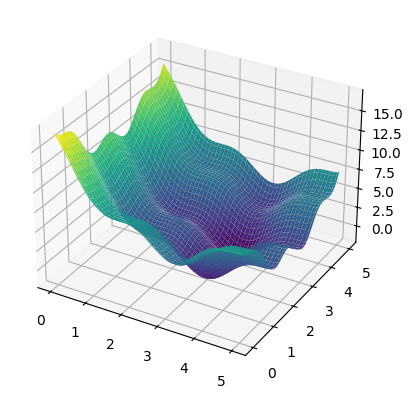

In [3]:
def f(x,y):
    "Objective function"
    return (x-3.14)**2 + (y-2.72)**2 + np.sin(3*x+1.41) + np.sin(4*y-1.73)
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# Compute and plot the function in 3D within [0,5]x[0,5]
x, y = np.array(np.meshgrid(np.linspace(0,5,100), np.linspace(0,5,100)))
z = f(x, y)


 
# plotting
ax.plot_surface(x, y, z, cmap='viridis')
plt.show()

As we can see from the plot above, this function looks like a curved egg carton. It is not a convex function and therefore it is hard to find its minimum because a local minimum found is not necessarily the global minimum.

So how can we find the minimum point in this function? For sure, we can resort to exhaustive search: If we check the value of $f(x,y)$ for every point on the plane, we can find the minimum point. Or we can just randomly find some sample points on the plane and see which one gives the lowest value on $f(x,y)$ if we think it is too expensive to search every point. However, we also note from the shape of $f(x,y)$ that if we have found a point with a smaller value of $f(x,y)$, it is easier to find an even smaller value around its proximity.

This is how a particle swarm optimization does. Similar to the flock of birds looking for food, we start with a number of random points on the plane (call them **particles**) and let them look for the minimum point in random directions. At each step, every particle should search around the minimum point it ever found as well as around the minimum point found by the entire swarm of particles. After certain iterations, we consider the minimum point of the function as the minimum point ever explored by this swarm of particles.

## Algorithm Details

Assume we have $P$ particles and we denote the position of particle $i$ at iteration $t$ as $X^i(t)$, which in the example of above, we have it as a coordinate X^i(t) = (x^i(t), y^i(t))$. Besides the position, we also have a velocity for each particle, denoted as $V^i(t) = (v^i_x(t), v^i_y(t))$. At the next iteration, the position of each particle would be updated as

$$
X^i(t+1) = X^i(t) + V^i(t+1)
$$

And at the same time, the velocities are also updated by the rule:

$$
V^i(t+1) = wV^i(t)+c_1r_1(pbest^i-X^i(t)) + c_2r_2(gbest-X^i(t))
$$

where $r_1$ and $r_2$ are random numbers between 0 and 1, constants $w$, $c_1$, and $c_2$ are parameters to the PSO algorithm, and $pbest^i$ is the position that gives the best $f(X)$ value ever explored by particle $i$ and $gbest$ is that explored by all the particles in the swarm.

We call the parameter $w$ the inertia weight constant. It is between 0 and 1 and determines how much should the particle keep on with its previous velocity (i.e., speed and direction of the search). The parameters $c_1$ and $c_2$ are called the cognitive and the social coefficients respectively. They controls how much weight should be given between refining the search result of the particle itself and recognizing the search result of the swarm. We can consider these parameters controls the trade off between **exploration** and **exploitation**.

The positions $pbest^i$ and $gbest$ are updated in each iteration to reflect the best position ever found thus far.

One interesting property of this algorithm that distinguishs it from other optimization algorithms is that it does not depend on the gradient of the objective function. In gradient descent, for example, we look for the minimum of a function $f(X)$ by moving $X$ to the direction $-\nabla f(X)$ of as it is where the function going down the fastest. For any particle at the position $X$ at the moment, how it moves does not depend on which direction is the “down hill” but only on where are $pbest^i$ and $gbest$. This makes PSO particularly suitable if differentiating $f(X)$ is difficult.

Another property of PSO is that it can be parallelized easily. As we are manipulating multiple particles to find the optimal solution, each particles can be updated in parallel and we only need to collect the updated value of
once per iteration. This makes map-reduce architecture a perfect candidate to implement PSO.

MovieWriter imagemagick unavailable; using Pillow instead.


PSO found best solution at f([3.18541756 3.12972478])=-1.8083516042208303
Global optimal at f([3.1818181818181817, 3.131313131313131])=-1.8082706615747688


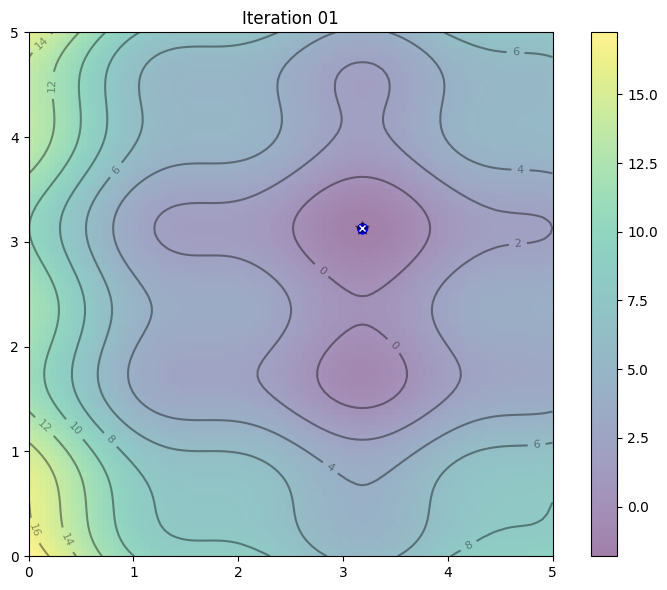

In [4]:
# Find the global minimum
x_min = x.ravel()[z.argmin()]
y_min = y.ravel()[z.argmin()]
 
# Hyper-parameter of the algorithm
c1 = c2 = 0.1
w = 0.8
 
# Create particles
n_particles = 20
np.random.seed(100)
X = np.random.rand(2, n_particles) * 5
V = np.random.randn(2, n_particles) * 0.1
 
# Initialize data
pbest = X
pbest_obj = f(X[0], X[1])
gbest = pbest[:, pbest_obj.argmin()]
gbest_obj = pbest_obj.min()
 
def update():
    "Function to do one iteration of particle swarm optimization"
    global V, X, pbest, pbest_obj, gbest, gbest_obj
    # Update params
    r1, r2 = np.random.rand(2)
    V = w * V + c1*r1*(pbest - X) + c2*r2*(gbest.reshape(-1,1)-X)
    X = X + V
    obj = f(X[0], X[1])
    pbest[:, (pbest_obj >= obj)] = X[:, (pbest_obj >= obj)]
    pbest_obj = np.array([pbest_obj, obj]).min(axis=0)
    gbest = pbest[:, pbest_obj.argmin()]
    gbest_obj = pbest_obj.min()
 
# Set up base figure: The contour map
fig, ax = plt.subplots(figsize=(8,6))
fig.set_tight_layout(True)
img = ax.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
pbest_plot = ax.scatter(pbest[0], pbest[1], marker='o', color='black', alpha=0.5)
p_plot = ax.scatter(X[0], X[1], marker='o', color='blue', alpha=0.5)
p_arrow = ax.quiver(X[0], X[1], V[0], V[1], color='blue', width=0.005, angles='xy', scale_units='xy', scale=1)
gbest_plot = plt.scatter([gbest[0]], [gbest[1]], marker='*', s=100, color='black', alpha=0.4)
ax.set_xlim([0,5])
ax.set_ylim([0,5])
 
def animate(i):
    "Steps of PSO: algorithm update and show in plot"
    title = 'Iteration {:02d}'.format(i)
    # Update params
    update()
    # Set picture
    ax.set_title(title)
    pbest_plot.set_offsets(pbest.T)
    p_plot.set_offsets(X.T)
    p_arrow.set_offsets(X.T)
    p_arrow.set_UVC(V[0], V[1])
    gbest_plot.set_offsets(gbest.reshape(1,-1))
    return ax, pbest_plot, p_plot, p_arrow, gbest_plot
 
anim = FuncAnimation(fig, animate, frames=list(range(1,50)), interval=500, blit=False, repeat=True)
anim.save("../resources/PSO.gif", dpi=120, writer="imagemagick")
 
print("PSO found best solution at f({})={}".format(gbest, gbest_obj))
print("Global optimal at f({})={}".format([x_min,y_min], f(x_min,y_min)))

![title](../resources/PSO.gif)

## Variations

All PSO algorithms are mostly the same as we mentioned above. In the above example, we set the PSO to run in a fixed number of iterations. It is trivial to set the number of iterations to run dynamically in response to the progress. For example, we can make it stop once we cannot see any update to the global best solution $gbest$ in a number of iterations.

Research on PSO were mostly on how to determine the hyperparameters $w$, $c_1$, and $c_2$ or varying their values as the algorithm progressed. For example, there are proposals making the inertia weight linear decreasing. There are also proposals trying to make the cognitive coefficient $c_1$ decreasing while the social coefficient $c_2$ increasing to bring more exploration at the beginning and more exploitation at the end.